<a href="https://colab.research.google.com/github/2359181042/GNN_cs224w/blob/main/Ireland_wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pytorch_lightning

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import os
import json
import numpy as np
import pandas as pd
DATA_PATH = 'gdrive/My Drive/Ireland_data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [3]:

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale = 1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=12,8
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. analyze our data 
  #### The data include eight wells between Galway City and Lahinch City in Ireland island. We consider the hourly data from 2016.11.28 13:00-2021.7.1 0:00: groundwater level, thelog_elevation, and the rain, temp and vapour pressure.

In [7]:
df=pd.read_csv(os.path.join(DATA_PATH,'Data.csv'))
loc=pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))
df['Date'] = pd.to_datetime(df['Time'])
df['Day'] = df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour']=df['Date'].dt.hour
df.index=df['Date']
df=df.drop(['Time'],axis=1)
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
cols = df.columns.tolist()
cols = cols[-4:]+cols[:-4]
df=df[cols]
df = df.rename(columns={'Lough Aleenaun': 'O1L', 'Unnamed: 2': 'O1E','Termon South':'O2L','Unnamed: 4':'O2E',  'Coole Lough':'O3L','Unnamed: 6':'O3E', 'Caherglassaun':'O4L','Unnamed: 8':'O4E', 'Black Rock':'O5L', 'Unnamed: 10':'O5E',
                        'Labane':'O6L','Unnamed: 12':'O6E','Caranavoodaun':'O7L', 'Unnamed: 14':'O7E'})


df.columns


Index(['Day', 'Month', 'Year', 'Hour', 'O1L', 'O1E', 'O2L', 'O2E', 'O3L',
       'O3E', 'O4L', 'O4E', 'O5L', 'O5E', 'O6L', 'O6E', 'O7L', 'O7E', 'rain',
       'temp', 'Vapour Pressure ', 'Date'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40140 entries, 2016-12-01 13:00:00 to 2021-07-01 00:00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Day               40140 non-null  int64         
 1   Month             40140 non-null  int64         
 2   Year              40140 non-null  int64         
 3   Hour              40140 non-null  int64         
 4   O1L               39720 non-null  float64       
 5   O1E               39720 non-null  float64       
 6   O2L               40140 non-null  float64       
 7   O2E               40140 non-null  float64       
 8   O3L               39391 non-null  float64       
 9   O3E               39391 non-null  float64       
 10  O4L               33890 non-null  float64       
 11  O4E               33890 non-null  float64       
 12  O5L               39476 non-null  float64       
 13  O5E               39476 non-null  float64

In [9]:
len(df['O2L'])

40140

<Figure size 1280x400 with 0 Axes>

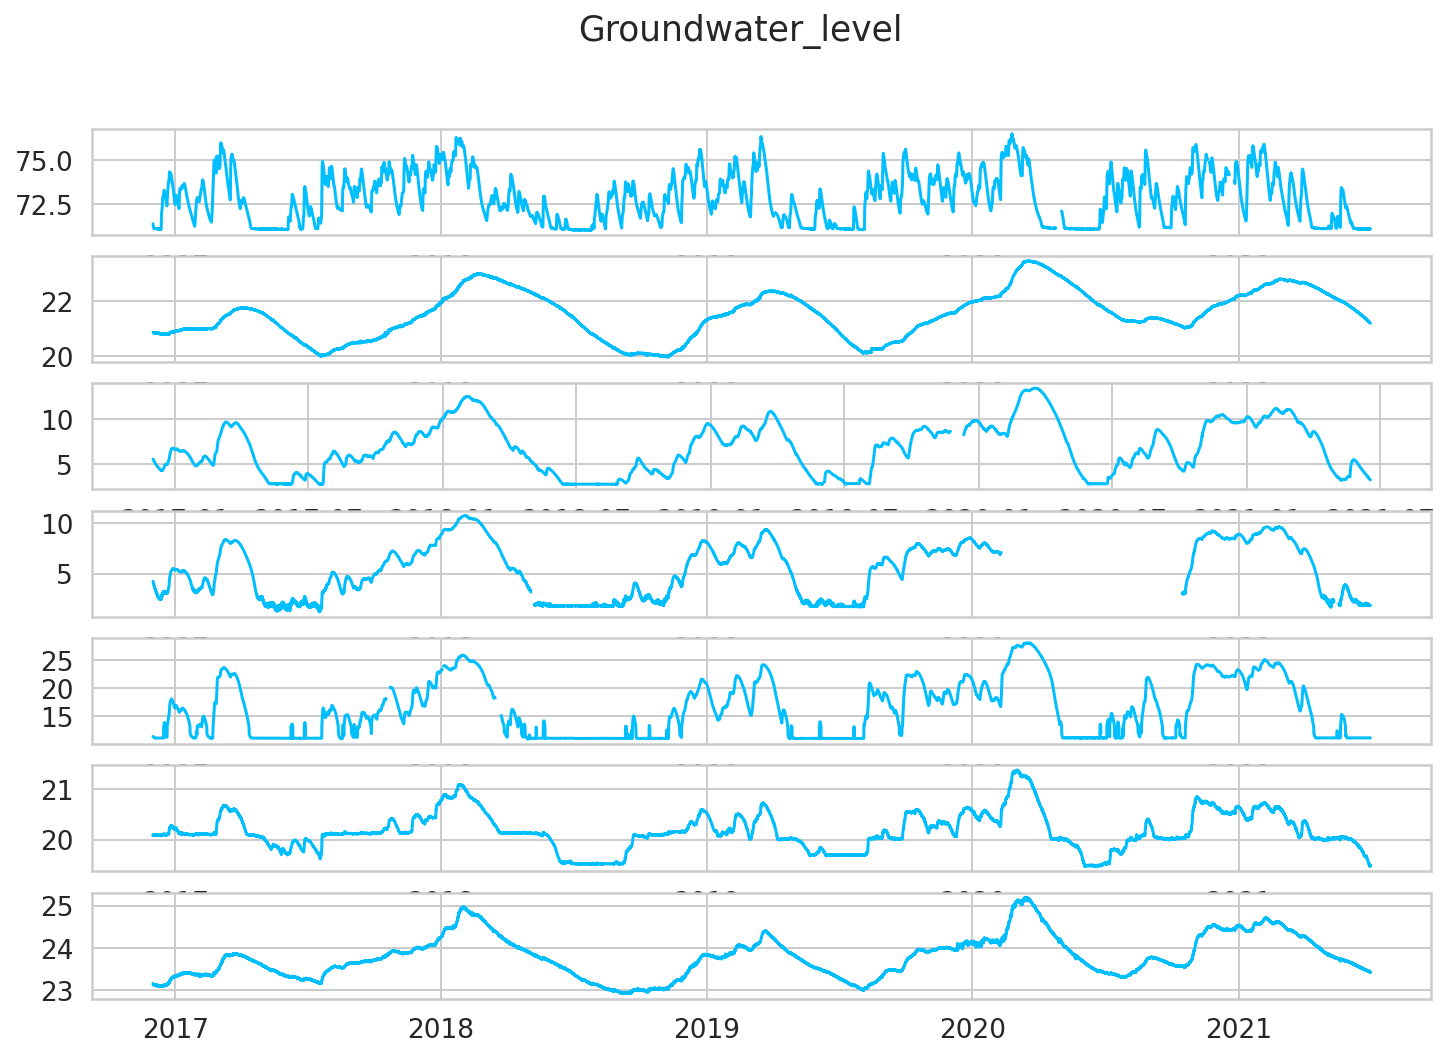

In [10]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(7)
fig.suptitle('Groundwater_level')
axs[0].plot(df.index, df['O1L'])
axs[1].plot(df.index, df['O2L'])
axs[2].plot(df.index, df['O3L'])
axs[3].plot(df.index, df['O4L'])
axs[4].plot(df.index, df['O5L'])
axs[5].plot(df.index, df['O6L'])
axs[6].plot(df.index, df['O7L'])


In [12]:
df2=df
df2['O1E']=df2['O1E'].fillna(method='ffill', axis=0)
df2['O3E']=df2['O3E'].fillna(method='ffill', axis=0)
df2['O5E']=df2['O5E'].fillna(method='ffill', axis=0)
df2['O1L']=df2['O1L'].fillna(method='ffill', axis=0)
df2['O3L']=df2['O3L'].fillna(method='ffill', axis=0)
df2['O5L']=df2['O5L'].fillna(method='ffill', axis=0)


<Figure size 1280x400 with 0 Axes>

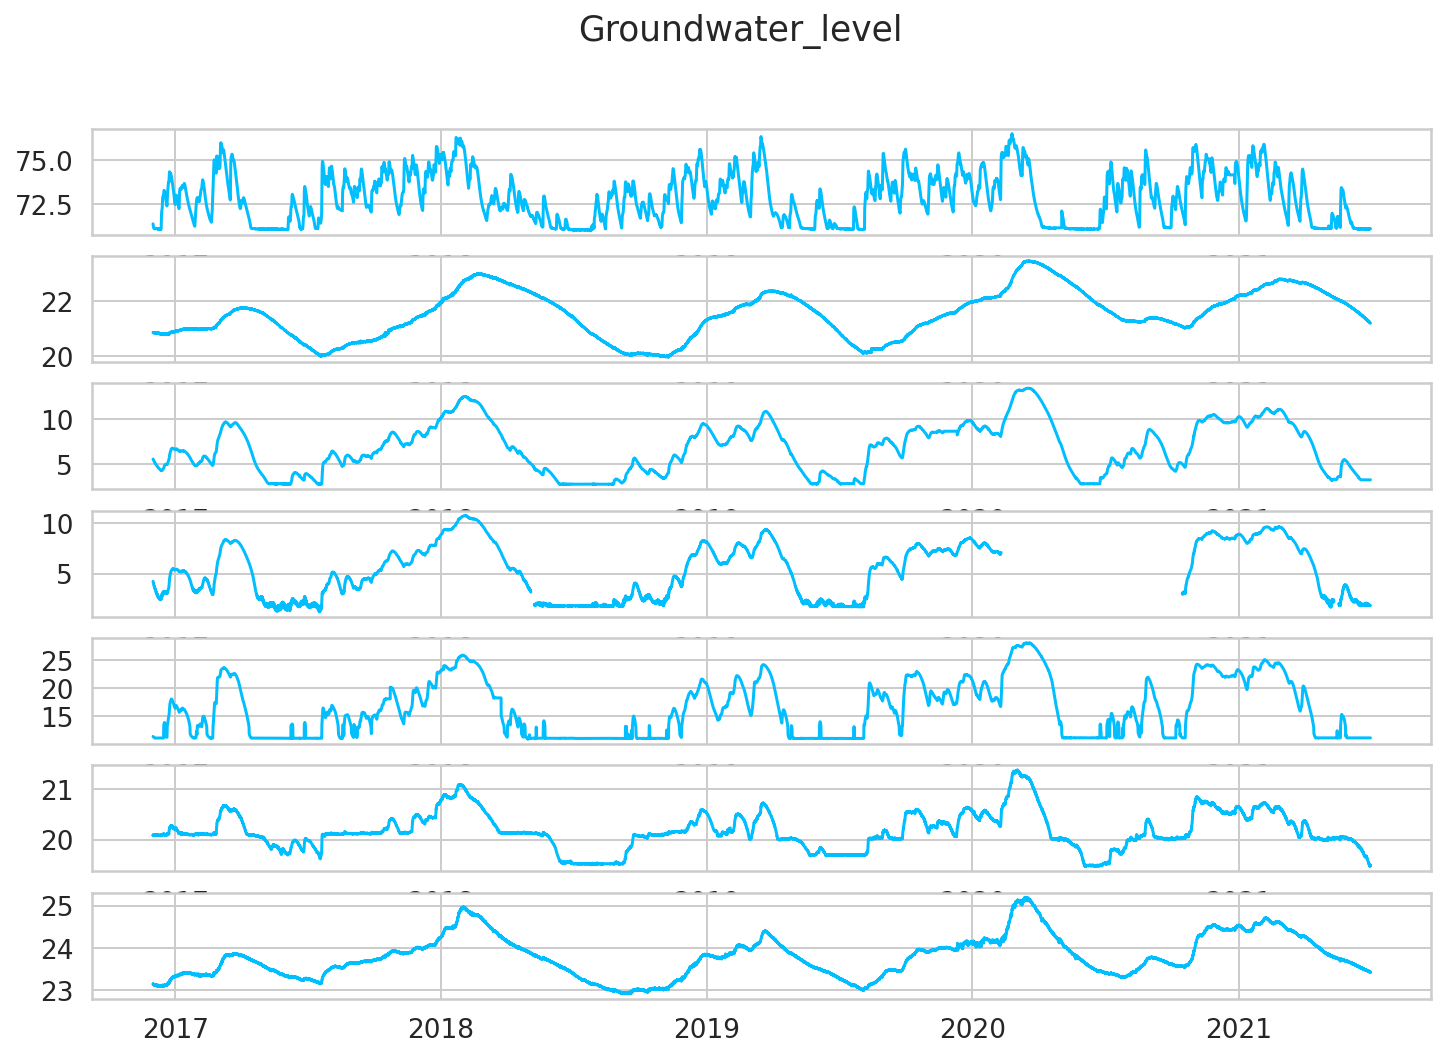

In [13]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(7)
fig.suptitle('Groundwater_level')
axs[0].plot(df2.index, df2['O1L'])
axs[1].plot(df2.index, df2['O2L'])
axs[2].plot(df2.index, df2['O3L'])
axs[3].plot(df2.index, df2['O4L'])
axs[4].plot(df2.index, df2['O5L'])
axs[5].plot(df2.index, df2['O6L'])
axs[6].plot(df2.index, df2['O7L'])

## Now the data are cleaned for 1 2 3 5 6 7, while 4 is lacking.

## The training data can be from 2017-2020,test data can be later

In [26]:
O1L=df2['O1L'].to_numpy()
print(O1L.shape)
O2L=df2['O2L'].to_numpy()
O3L=df2['O3L'].to_numpy()
O4L=df2['O4L'].to_numpy()
O5L=df2['O5L'].to_numpy()
O6L=df2['O6L'].to_numpy()
O7L=df2['O7L'].to_numpy()
print(O4L.shape)
O1E=df2['O1E'].to_numpy()
print(O1L.shape)
O2E=df2['O2E'].to_numpy()
O3E=df2['O3E'].to_numpy()
O4E=df2['O4E'].to_numpy()
O5E=df2['O5E'].to_numpy()
O6E=df2['O6E'].to_numpy()
O7E=df2['O7E'].to_numpy()
rain=df2['rain'].to_numpy()
temp=df2['temp'].to_numpy()
vp=df2['Vapour Pressure '].to_numpy()
Day=df2['Day'].to_numpy()
Month=df2['Month'].to_numpy()
Year=df2['Year'].to_numpy()
Hour=df2['Hour'].to_numpy()

(40140,)
(40140,)
(40140,)


In [30]:

Well_location= pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))

NE=[]
North=[]
East=[]
for i in range(7):
    N=Well_location.iloc[0][i]
    North.append(N)
    E=Well_location.iloc[1][i]
    East.append(E)
    NE.append((N,E))
print(len(NE))

7


In [32]:
from math import sin, cos, sqrt, atan2, radians
R = 6378.1370
specific_distance=10
def get_conn_attr(N,E):
    Distance = []
    con_i=[]
    con_j=[]
    for i in range(len(N)):
        for j in range(len(N)):
                lat1 = radians(N[i])
                lon1 = radians(E[i])
                lat2 = radians(N[j])
                lon2 = radians(E[j])
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                distance = R * c
                if (distance < specific_distance) & (distance > 0):
                    con_i.append(i)
                    con_j.append(j)
                    Distance.append(distance)

    conn=torch.tensor([con_i,con_j])
    edge_attr = torch.tensor([Distance])
    edge_attr = edge_attr.transpose(0, 1) 
    edge_attr = edge_attr.unsqueeze(0).repeat(18,1,1)
    return conn, edge_attr

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import os
import json
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians

TIME_WINDOW = 18
PRED_TIME = 18

def create_dataset()